# Récupération et traitement des données OSM de la France (niveau 4, régions)

Il semble que le contour continental de la France ne soit pas directement disponible. On récupère donc les régions séparément.

## Récuération de la liste des régions

In [1]:
import requests
import json

# on cherche toutes les régions de France

overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area[name="France"][boundary];
 rel(area)[boundary][admin_level=4];
 map_to_area;
 foreach->.d(
   (.d;);out;
 );
"""
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
data = response.json()

In [2]:
sorted([e['tags']['name'] for e in data['elements']])

['Auvergne-Rhône-Alpes',
 'Bourgogne-Franche-Comté',
 'Bretagne',
 'Centre-Val de Loire',
 'Corse',
 'Grand Est',
 'Guadeloupe',
 'Guyane',
 'Hauts-de-France',
 'La Réunion',
 'Martinique',
 'Mayotte',
 'Normandie',
 'Nouvelle-Aquitaine',
 'Occitanie',
 'Pays de la Loire',
 "Provence-Alpes-Côte d'Azur",
 'Province apostolique de Normandie',
 "Valle d'Aosta/Vallée d'Aoste",
 'Île Tromelin',
 'Île Tromelin',
 'Île-de-France']

In [3]:
# on ne garde que les plus pertinentes
regions = [
    'Auvergne-Rhône-Alpes',
    'Bourgogne-Franche-Comté',
    'Bretagne',
    'Centre-Val de Loire',
    'Corse',
    'Grand Est',
    'Guadeloupe',
    'Guyane',
    'Hauts-de-France',
    'La Réunion',
    'Martinique',
    'Mayotte',
    'Normandie',
    'Nouvelle-Aquitaine',
    'Occitanie',
    'Pays de la Loire',
    "Provence-Alpes-Côte d'Azur",
    'Île-de-France']

## Récupérations des données régionales de contour

In [4]:
import gzip

# données géométriques au format JSON
for r in regions:
    overpass_query = """
[out:json];
relation[boundary=administrative][admin_level=4][name="{}"];
out geom;
""".format(r)
    response = requests.get(overpass_url, params={'data': overpass_query})
    with gzip.open("data/{}.geom.json.gz".format(r), 'w') as f:
        f.write(response.content)

In [5]:
# données géométriques au format XML
for r in regions:
    overpass_query = """
relation[boundary=administrative][admin_level=4][name="{}"];
out geom;
""".format(r)
    response = requests.get(overpass_url, params={'data': overpass_query})
    with gzip.open("data/{}.geom.osm.gz".format(r), 'w') as f:
        f.write(response.content)

In [6]:
# métadonnées au format JSON
for r in regions:
    overpass_query = """
[out:json];
relation[boundary=administrative][admin_level=4][name="{}"];
out;
""".format(r)
    response = requests.get(overpass_url, params={'data': overpass_query})
    with gzip.open("data/{}.metadata.json.gz".format(r), 'w') as f:
        f.write(response.content)

In [7]:
# métadonnées au format XML
for r in regions:
    overpass_query = """
relation[boundary=administrative][admin_level=4][name="{}"];
out;
""".format(r)
    response = requests.get(overpass_url, params={'data': overpass_query})
    with gzip.open("data/{}.metadata.osm.gz".format(r), 'w') as f:
        f.write(response.content)

## Traitement pour retrouver un contour ordonné

In [8]:
import json
import gzip

def contours(region=None, ways=None):
    # l'ordre des chemins n'est pas assuré mais on peut le retrouver :
    # https://gis.stackexchange.com/questions/119728/how-do-you-get-the-nodes-of-an-area-in-overpass-api-in-the-right-order
    if region is not None:
        data = json.load(gzip.open("data/{}.geom.json.gz".format(region)))
        ways = [[(p['lat'], p['lon']) for p in m['geometry']]
                for e in data['elements'] for m in e['members']
                if m['type'] == 'way' and m['role'] == 'outer']
    else:
        assert ways is not None
    
    # on construit le dico des chemins indicés par le premier point
    # (les chemins sont ajoutés dans les deux sens)
    res = {}
    for way in ways: 
        start, end = way[0], way[-1]

        if start in res:
            way = res[start][::-1] + way[1:]
            del res[start]
        if way[0] != way[-1] and end in res:
            way = way + res[end][1:]
            del res[end]
        res[way[0]] = way
        res[way[-1]] = way[::-1]

    for k, c in res.items():
        assert c[0] == c[-1], len(c)

    return sorted(res.values(), key=lambda x: len(x), reverse=True)

In [9]:
for r in regions:
    json.dump(contours(r), gzip.open("data/{}.borders.json.gz".format(r), 'wt'))

## Extraction des données continentales

In [10]:
for r in regions:
    data = json.load(gzip.open("data/{}.borders.json.gz".format(r)))[0]
    json.dump(data, gzip.open("data/{}.continental-borders.json.gz".format(r), 'wt'))

## Représentation en Lambert93 pour vérifier

In [11]:
import numpy as np
from pyproj import Transformer

def projete(points):
    transformer = Transformer.from_crs(4326, 2154)
    pts = np.asarray(points)
    return np.asarray(transformer.transform(pts[:, 0], pts[:, 1])).T

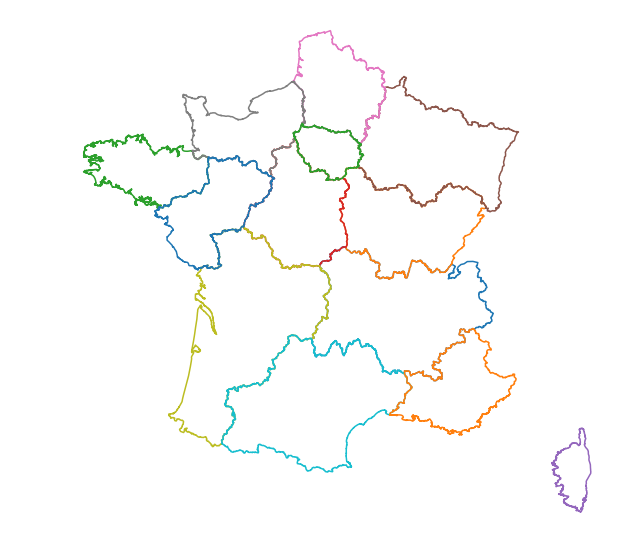

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(aspect='equal')
for r in regions:
    if r in {"La Réunion", "Guadeloupe", "Guyane", "Martinique", "Mayotte"}: continue
    c = json.load(gzip.open("data/{}.continental-borders.json.gz".format(r)))
    pts = projete(c)
    ax.plot(pts[:, 0], pts[:, 1])
plt.axis("off")
plt.show()

## Construction du contour de la France

In [13]:
def union(region_list):
    # suppression des chemins qui apparaissent en double
    ways = {}
    for r in region_list:
        data = json.load(gzip.open("data/{}.geom.json.gz".format(r)))
        for e in data['elements']:
            for m in e['members']:
                if m['type'] != 'way' or m['role'] != 'outer':
                    continue
                ref = m['ref']
                if ref in ways:
                    del ways[ref]
                else:
                    ways[ref] = [(p['lat'], p['lon']) for p in m['geometry']]
    return contours(ways=ways.values())

In [14]:
france = union(regions)

In [15]:
json.dump(france, gzip.open("data/france.borders.json.gz", 'wt'))

In [16]:
json.dump(france[0], gzip.open("data/france.continental-borders.json.gz", 'wt'))

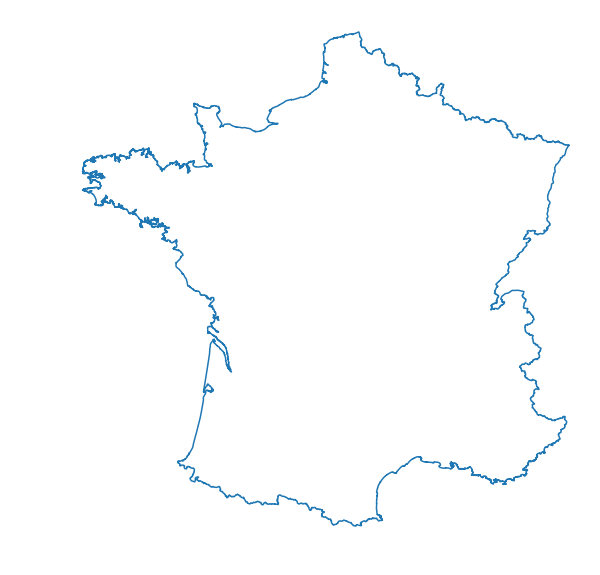

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(aspect='equal')
for c in france[:1]:
    pts = projete(c)
    ax.plot(pts[:, 0], pts[:, 1])
plt.axis("off")
plt.show()